In [1]:
import sys
import os

In [2]:
print(os.getcwd())

/home/hchen/PycharmProjects/ICDE23/GNNquery/SkylineGNN_py/utilities


In [3]:
import torch

In [4]:
print(torch.__version__)
print(torch.version.cuda)

1.11.0
None


In [5]:
# sys.path.append('/home/gqxwolf/mydata/GNN_Combinatroal/skylineGNN/Base001')
# sys.path.append('/home/qixugong/skylineGNN/code/004')
sys.path.append('/home/hchen/PycharmProjects/ICDE23/GNNquery/SkylineGNN_py/validation')
sys.path.append('/home/hchen/PycharmProjects/ICDE23/GNNquery/SkylineGNN_py/utilities')
print(sys.path)

['/home/hchen/.local/share/JetBrains/Toolbox/apps/PyCharm-P/ch-0/222.4167.33/plugins/python/helpers-pro/jupyter_debug', '/home/hchen/.local/share/JetBrains/Toolbox/apps/PyCharm-P/ch-0/222.4167.33/plugins/python/helpers/pydev', '/home/hchen/PycharmProjects/ICDE23/GNNquery/SkylineGNN_py/utilities', '/home/hchen/PycharmProjects/ICDE23/GNNquery', '/home/hchen/anaconda3/envs/GNNquery/lib/python39.zip', '/home/hchen/anaconda3/envs/GNNquery/lib/python3.9', '/home/hchen/anaconda3/envs/GNNquery/lib/python3.9/lib-dynload', '', '/home/hchen/anaconda3/envs/GNNquery/lib/python3.9/site-packages', '/home/hchen/PycharmProjects/ICDE23/GNNquery/SkylineGNN_py/validation', '/home/hchen/PycharmProjects/ICDE23/GNNquery/SkylineGNN_py/utilities']


In [6]:
from torch.nn import CrossEntropyLoss, BCELoss, BCEWithLogitsLoss
from torch_geometric.data import DataLoader
# from torch_geometric.loader import DataLoader
import numpy as np
from model import GraphEncoder
from readData import LoadData, LoadGraph
import os
from MultiCostNetworks import MultiCostNetworks
import torch.nn.functional as F
from drawRawGraphs import draw_graph
import time
from torch_geometric.utils import subgraph, k_hop_subgraph
import math

In [7]:
from readCheckPoints import getMaxCheckPointName
from MultiCostNetworks import MultiCostNetworks
from readData import LoadData, LoadGraph
from model import GraphEncoder
from drawRawGraphs import draw_graph_with_DataObj

In [14]:
# path = "/home/gqxwolf/mydata/projectData/skylineGNN/dataset/C9_NY_5K"
# train_paths_folder = "/home/gqxwolf/mydata/projectData/skylineGNN/results_back/C9_NY_5K/results"
# check_point_file = '/home/gqxwolf/mydata/projectData/skylineGNN/models/C9_NY_5K/SAGE_models/baseline/256_256_32_1000_1_EmbedTrue_5000_train_checkpoint_SAGE_ConLossFalse_2GNN3FF_10k_train_samples.pt'
# data_folder = "/home/gqxwolf/mydata/projectData/skylineGNN/processed/C9_NY_5K/1"
path = "/home/hchen/IntelliJProjects/java_SkylineGNN/Data/C9_NY/C9_NY_NONE/C9_NY_NONE_5K"
train_paths_folder = "/home/hchen/IntelliJProjects/java_SkylineGNN/Data/results_bbs/C9_NY/C9_NY_NONE_5K_1200"
data_folder = "/home/hchen/IntelliJProjects/java_SkylineGNN/Data/C9_NY/C9_NY_NONE/C9_NY_NONE_5K"
checkpoint_folder = '/home/hchen/PycharmProjects/ICDE23/GNNquery/SkylineGNN_py/checkpoints/'
check_point_file = checkpoint_folder + '128_64_16_0_1_EmbedTrue_5000_train_checkpoint_Transformer_ConLossTrue_2GNN3FF_10k_train_samples.pt'

print(path)
print(train_paths_folder)
print(check_point_file)
print(data_folder)

/home/hchen/IntelliJProjects/java_SkylineGNN/Data/C9_NY/C9_NY_NONE/C9_NY_NONE_5K
/home/hchen/IntelliJProjects/java_SkylineGNN/Data/results_bbs/C9_NY/C9_NY_NONE_5K_1200
/home/hchen/PycharmProjects/ICDE23/GNNquery/SkylineGNN_py/checkpoints/128_64_16_0_1_EmbedTrue_5000_train_checkpoint_Transformer_ConLossTrue_2GNN3FF_10k_train_samples.pt
/home/hchen/IntelliJProjects/java_SkylineGNN/Data/C9_NY/C9_NY_NONE/C9_NY_NONE_5K


In [26]:
n_nodes = 5000
node_dim = 2
edge_dim = 3
embedding_dim = 128
hidden_dim = 64
batch_size = 16
enable_embed = True
output_dim = 3
model_name = "Transformer"
heads = 1
conn_loss_enable = True
enable_edge_attr= True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# init model


cpu


In [10]:
print('Using GPU, %i devices.' % torch.cuda.device_count())

from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

Using GPU, 0 devices.


ModuleNotFoundError: No module named 'pynvml'

In [16]:
num_node, graph = LoadGraph(path, logger=None, normalization_node=True, normalization_edge=True)
graph_size = num_node
print("==========================================")

train_dataset = MultiCostNetworks(graph, train_paths_folder=train_paths_folder, root=data_folder, split='train')
test_dataset = MultiCostNetworks(graph, train_paths_folder=train_paths_folder, root=data_folder, split='test')
train_loader = DataLoader(train_dataset, drop_last=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, drop_last=True, batch_size=batch_size)
# sys.exit(0)

/home/hchen/anaconda3/envs/GNNquery/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
model = GraphEncoder(node_dim, edge_dim, embedding_dim, hidden_dim, output_num_class=output_dim, device=device, enable_embedding=enable_embed,
                     batch=batch_size, model_name=model_name, heads=heads).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

Transformer model, edge dim:3 with multi-heads attention 1
Transformer model, edge dim:3 with multi-heads attention 1
Finish model initialization !!!!


In [18]:
checkpoint = torch.load(check_point_file,map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
resume_epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [21]:
# @torch.no_grad()
# def test(data):
#     model.eval()
#
#     total_loss = 0
#     total_pre_n = 0
#     total_n = 0
#     total_graphs = 0
#     total_conn_lost = 0
#     total_nll_lost = 0
#
#     # data = data.to(device)
#     logits = model(data)
#
#     loss = F.nll_loss(logits, data.y)
#     total_nll_lost += loss.item() * data.num_graphs
#
#     if conn_loss_enable:
#         c_loss = (1/graph_size)*(-math.log(model.connectivity_loss(logits, data)))
#         total_conn_lost += c_loss * data.num_graphs
#         loss = loss+c_loss
#
#     total_pre_n += (np.argmax(logits.cpu().detach().numpy(), axis=1) == 1).sum() + (
#             np.argmax(logits.cpu().detach().numpy(), axis=1) == 2).sum()
#     total_n += ((data.y.cpu().detach().numpy() == 1).sum())
#
#     total_graphs += data.num_graphs
#
#     total_loss += loss.item() * data.num_graphs
#     print(data.num_graphs, total_n, total_pre_n)
#
#         # if n!=0:
#         #     print(count, np.argmax(logits.cpu().numpy(),axis=1), n )
#         #     sys.exit()
#
#     return total_loss / data.num_graphs, total_nll_lost/data.num_graphs, total_conn_lost/data.num_graphs, total_pre_n / total_graphs, total_n / total_graphs, logits

In [27]:
@torch.no_grad()
def test(data):
    model.eval()

    total_loss = 0
    total_pre_n = 0
    total_n = 0
    total_graphs = 0
    total_conn_lost = 0
    total_nll_lost = 0

    data = data
    logits = model(data, n_nodes)

    loss = F.nll_loss(logits, data.y)
    total_nll_lost += loss.item() * data.num_graphs

    if conn_loss_enable:
        c_loss = (1/graph_size) * \
            (-math.log(model.connectivity_loss(logits, data)))
        total_conn_lost += c_loss * data.num_graphs
        loss = loss+c_loss

    total_pre_n += (np.argmax(logits.cpu().detach().numpy(), axis=1) == 1).sum() + (
        np.argmax(logits.cpu().detach().numpy(), axis=1) == 2).sum()
    total_n += ((data.y.cpu().detach().numpy() == 1).sum())

    total_graphs += data.num_graphs

    total_loss += loss.item() * data.num_graphs
    print(data.num_graphs, total_n, total_pre_n)

    # if n!=0:
    #     print(count, np.argmax(logits.cpu().numpy(),axis=1), n )
    #     sys.exit()

    return total_loss / data.num_graphs, total_nll_lost/data.num_graphs, total_conn_lost/data.num_graphs, total_pre_n / total_graphs, total_n / total_graphs, logits

In [28]:
batch_num = 2
i = 23
n = num_node
grahp_size = num_node
test_data = None

for index, data in enumerate(test_loader):
    print(index)
    if index == batch_num:
      test_data = data
      break

print(test_data)

start_time = time.time()
val_auc, test_nll_loss, test_conn_loss, test_p_n, test_n, logits = test(test_data)
end_time = time.time()
print("Val:{:.4f}({:.5f}+{:.5f})[{:.5f} - {:.5f}], running time each epoch:{:.2f}".format(
            val_auc, test_nll_loss, test_conn_loss, test_p_n, test_n, (end_time - start_time)))

# i = 16
# n = graph_size
graph = test_data.to_data_list()[i]
print(graph)

predictions = np.argmax(logits[i*n:(i+1)*n, :].cpu().detach().numpy(), axis=1)
data_y = data.y.cpu().detach().numpy()[i*n:(i+1)*n]
pre_n_i = (predictions == 1).sum() + (predictions == 2).sum()
total_n_i = (data_y == 1).sum()+(data_y == 2).sum()

print("{} / {} ===== overall:{} / {} in {} second".format(pre_n_i, total_n_i, test_p_n, test_n, end_time - start_time))


draw_graph_with_DataObj(graph, data_y, test_data.src_node_idx[i].item(), test_data.dest_node_idx[i].item())
draw_graph_with_DataObj(graph, predictions, test_data.src_node_idx[i].item(), test_data.dest_node_idx[i].item())

0
None


AttributeError: 'NoneType' object has no attribute 'x'

In [16]:
print(predictions.shape, data_y.shape)
print(pre_n_i, total_n_i)

(5000,) (5000,)
175 194


4511 3161 5000 174
1


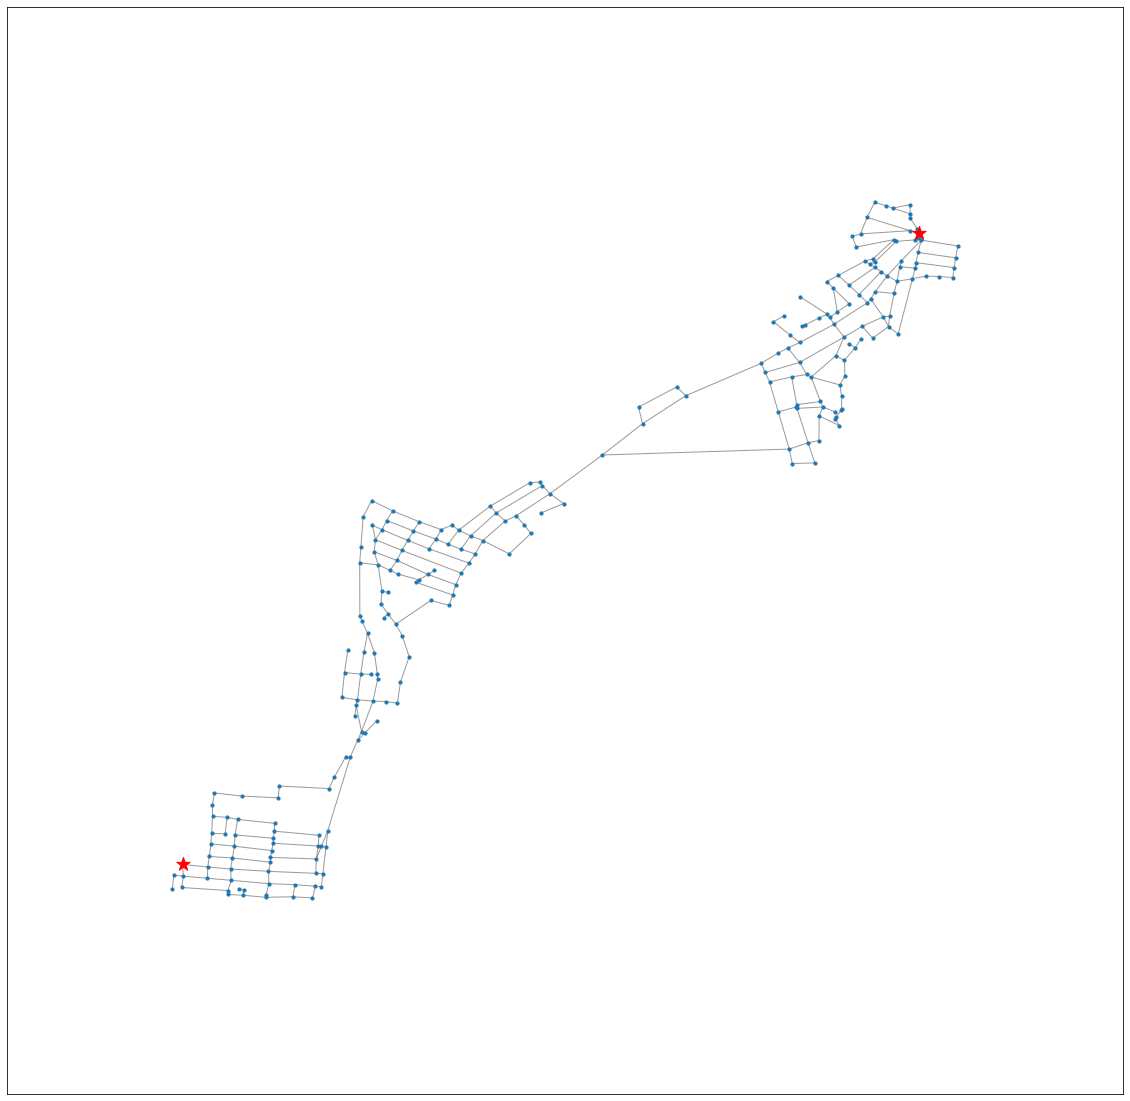

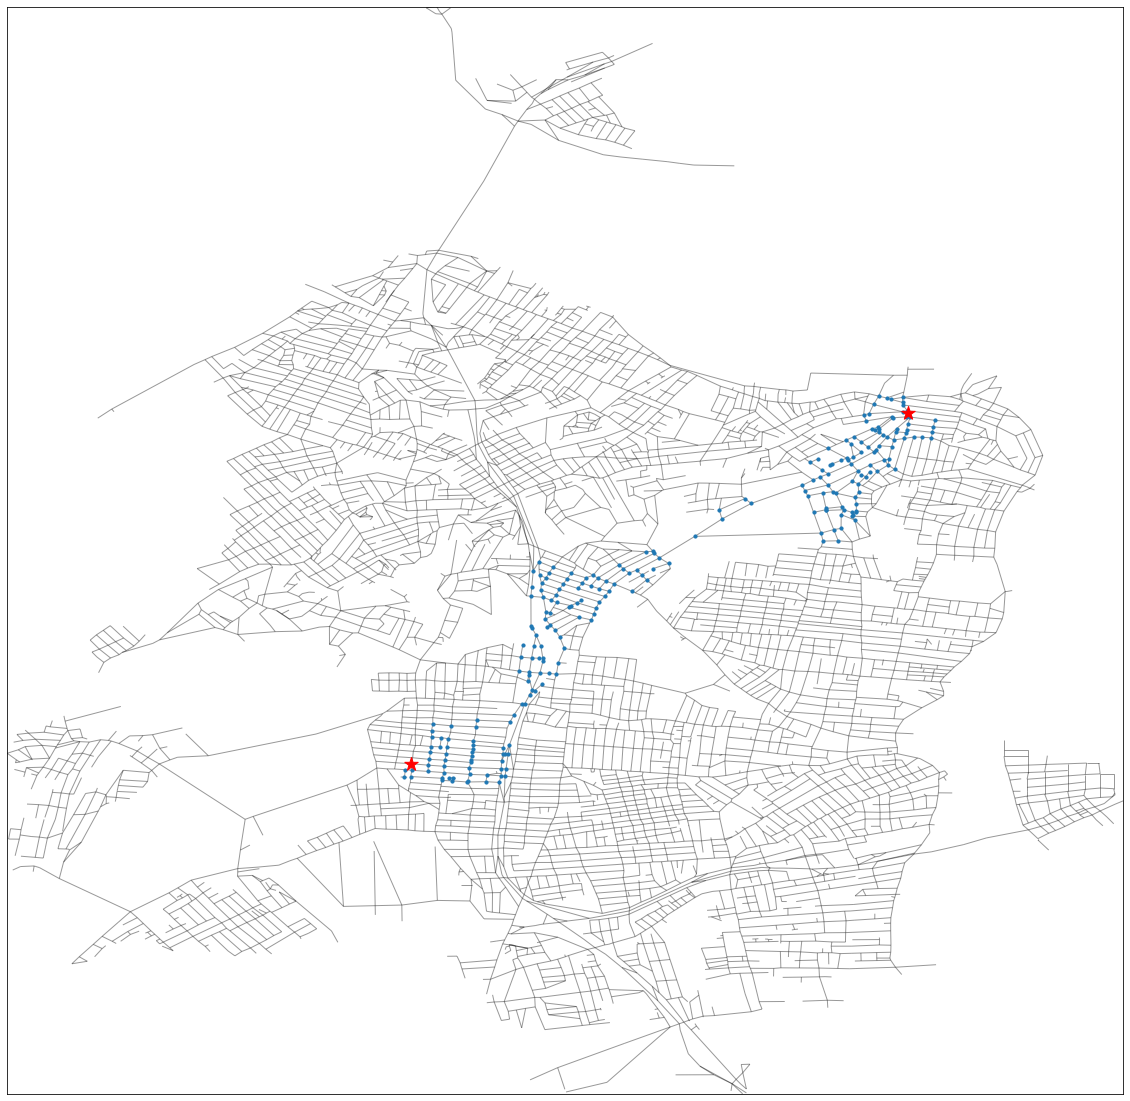

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils.convert import to_networkx
import numpy as np
import sys

# plt.figure(figsize=(20, 20))
# # print(graph.edge_attr.list())
# print(type(predictions))
# print(np.where(predictions==1))
# print(np.where(predictions==1)[0].tolist())

n_graph = to_networkx(graph, to_undirected=True, remove_self_loops=False)
src = test_data.src_node_idx[i].item()
dest = test_data.dest_node_idx[i].item()
target_node_list = np.where(predictions == 1)[0].tolist()
print(src, dest, len(n_graph.nodes), len(target_node_list))

sub_node_set = set()
for idx, node in enumerate(target_node_list):
    s_path = nx.dijkstra_path(n_graph, node, src)
    d_path = nx.dijkstra_path(n_graph, node, dest)
    # print(idx, ":", node, len(s_path), len(d_path))
    sub_node_set.update(s_path)
    sub_node_set.update(d_path)
sub_node_set.add(src)
sub_node_set.add(dest)
# print(sub_node_set)

plt.figure(figsize=(20, 20))
sb = n_graph.subgraph(sub_node_set).copy()
print(nx.number_connected_components(sb))

max_x = max_y = 0
min_x = min_y = 1
n_post = {}
for idx, n in enumerate(graph.x):
    # print(idx, n[0].item(), n[1].item())
    if idx in sub_node_set:
        n_post[idx] = [n[0].item(), n[1].item()]

        if n[0].item() > max_x:
            max_x = n[0].item()
        if n[0].item() < min_x:
            min_x = n[0].item()

        if n[1].item() > max_y:
            max_y = n[1].item()
        if n[1].item() < min_y:
            min_y = n[1].item()


# print(n_post)
nx.draw_networkx_edges(sb, n_post, alpha=0.4)
nx.draw_networkx_nodes(sb, n_post,
                       sub_node_set,
                       node_size=10,
                       # node_color=list(p.values()),
                       cmap=plt.cm.Reds_r)
nx.draw_networkx_nodes(sb, {src: [graph.x[src][0].item(), graph.x[src][1].item()], dest: [graph.x[dest][0].item(),graph.x[dest][1].item()]},
                       [src, dest],
                       node_size=200,
                       node_shape='*',
                       node_color='r')

plt.xlim(min_x-0.1, max_x+0.1)
plt.ylim(min_y-0.1, max_y+0.1)
plt.show()
plt.show()

plt.figure(figsize=(20, 20))
pos = {}
for idx, n in enumerate(graph.x):
    # print(idx, n[0].item(), n[1].item())
    pos[idx] = [n[0].item(), n[1].item()]
# print(pos)

nx.draw_networkx_edges(n_graph, pos, alpha=0.4)
nx.draw_networkx_nodes(n_graph, pos,
                       sub_node_set,
                       node_size=10,
                       # node_color=list(p.values()),
                       cmap=plt.cm.Reds_r)
nx.draw_networkx_nodes(n_graph, {src: [graph.x[src][0].item(), graph.x[src][1].item()], dest: [graph.x[dest][0].item(),graph.x[dest][1].item()]},
                       [src, dest],
                       node_size=200,
                       node_color='r',
                       node_shape='*')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
